In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
import matplotlib.colors as colors
import cmocean.cm as cmo
from glob import glob
import xgcm

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 62.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39849,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 62.81 GiB
Comm: tcp://127.0.0.1:38135,Total threads: 2
Dashboard: http://127.0.0.1:37425/status,Memory: 15.70 GiB
Nanny: tcp://127.0.0.1:34259,


In [3]:
import datetime
import nc_time_axis

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy
import matplotlib.path as mpath

In [158]:
GRIDT_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-T_clim/*gridTclim.nc"
ICEMOD_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-icemod_clim/*icemodclim.nc"
NSQUARE_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-Nsquared/clim/*5d_Nsquared.nc"
EKE_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-EKE/clim/*EKEclim.nc"
MKE_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-MKE/clim/*MKE.nc"
SHEAR_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-shear/clim/*shear.nc"

In [159]:
GRIDT_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-T_clim/*gridTclim.nc"
ICEMOD_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-icemod_clim/*icemodclim.nc"
NSQUARE_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-Nsquared/clim/*5d_Nsquared.nc"
EKE_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-EKE/clim/*EKEclim.nc"
MKE_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-MKE/clim/*MKE.nc"
SHEAR_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-shear/clim/*shear.nc"

In [7]:
def prepro(ds):
    return ds.isel(y=slice(800, None))

In [8]:
grid_files = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc"
coords_file = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/coordinates_CREG12_lbclnk_noz_vh20160930.nc"
mask_file= "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc"


In [9]:
grid = xr.open_mfdataset(grid_files, parallel=True, preprocess=prepro)
coords = xr.open_mfdataset(coords_file, parallel=True, preprocess=prepro)
mask = xr.open_mfdataset(mask_file, parallel=True, preprocess=prepro)

# Density

In [10]:
GRIDT_REF = xr.decode_cf(xr.open_mfdataset(GRIDT_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 5}))

GRIDT_REF = GRIDT_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [11]:
GRIDT_FUT = xr.decode_cf(xr.open_mfdataset(GRIDT_data_filesFUT, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 5}))

GRIDT_FUT = GRIDT_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [23]:
from utils import *

In [13]:
index_y ,index_x = extract_transect('','',GRIDT_REF)

In [14]:
ds_xi = xr.DataArray(index_x.ravel(), dims=["x_points"])
ds_yi = xr.DataArray(index_y.ravel(), dims=["y_points"])

In [18]:
transect_REF = GRIDT_REF.rhop_sig0.isel(deptht=slice(0,40)).assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)
transect_FUT = GRIDT_FUT.rhop_sig0.isel(deptht=slice(0,40)).assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)

In [19]:
diag = xr.DataArray(np.arange(700), dims="diag")
diag_transect_REF = transect_REF.isel(x_points=diag, y_points=diag)
diag_transect_FUT = transect_FUT.isel(x_points=diag, y_points=diag)

In [44]:
data2plot_REF_rho = diag_transect_REF.mean('time_counter').compute()
data2plot_FUT_rho = diag_transect_FUT.mean('time_counter').compute()

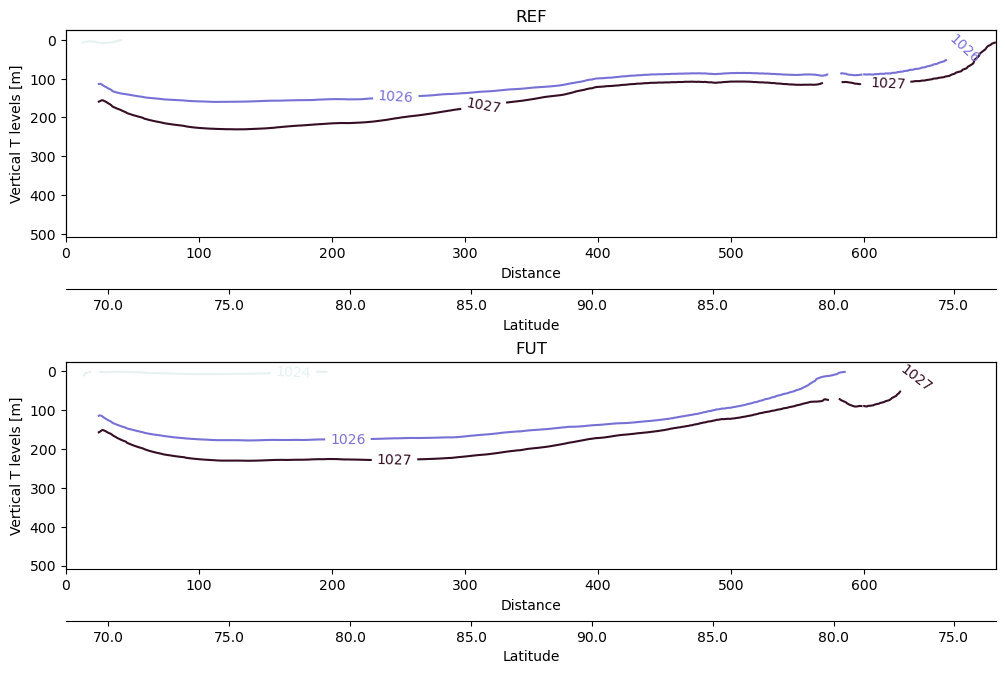

In [45]:
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(2, 1, 1)
cs = data2plot_REF_rho.where(data2plot_REF> 1000).plot.contour(x='diag', ax=ax1,vmin=1020,vmax=1030,cmap=cmo.dense,levels=[1024,1026,1027])
ax1.clabel(cs, inline=1, fontsize=10)
ax1.set_title("REF")


ax2 = fig.add_subplot(2, 1, 2)
cs = data2plot_FUT_rho.where(data2plot_FUT> 1000).plot.contour(x='diag',ax=ax2,vmin=1020,vmax=1030,cmap=cmo.dense,levels=[1024,1026,1027])
ax2.clabel(cs, inline=1, fontsize=10)
ax2.set_title("FUT")

ax1.invert_yaxis()
ax2.invert_yaxis()

ax1.set_xlabel('Distance')
ax2.set_xlabel('Distance')

ax1_t = create_extra_axis(ax1)
ax2_t = create_extra_axis(ax2)

fig.canvas.draw()

labels = [item.get_text() for item in ax1_t.get_xticklabels()]
labels = [np.round(data2plot_REF.nav_lat.isel(diag=int(label)).values) for label in labels]

ax1_t.set_xticklabels(labels)
ax1_t.set_xlabel('Latitude')
ax2_t.set_xticklabels(labels)
ax2_t.set_xlabel('Latitude')

plt.subplots_adjust(hspace=0.6)

plt.savefig('PV_horizontal_gradient_REF_FUT.pdf')

# ICE

In [235]:
ICEMOD_REF = xr.decode_cf(xr.open_mfdataset(ICEMOD_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 5}))

ICEMOD_REF = ICEMOD_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [241]:
ICEMOD_FUT = xr.decode_cf(xr.open_mfdataset(ICEMOD_data_filesFUT, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 5}))

ICEMOD_FUT = ICEMOD_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [237]:
transect_REF = ICEMOD_REF.sithic.assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)
transect_FUT = ICEMOD_FUT.sithic.assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)

In [238]:
diag = xr.DataArray(np.arange(700), dims="diag")
diag_transect_REF = transect_REF.isel(x_points=diag, y_points=diag)
diag_transect_FUT = transect_FUT.isel(x_points=diag, y_points=diag)

In [242]:
data2plot_REF_icethick = diag_transect_REF.mean('time_counter').compute()
data2plot_FUT_icethick = diag_transect_FUT.mean('time_counter').compute()

# Ice + density

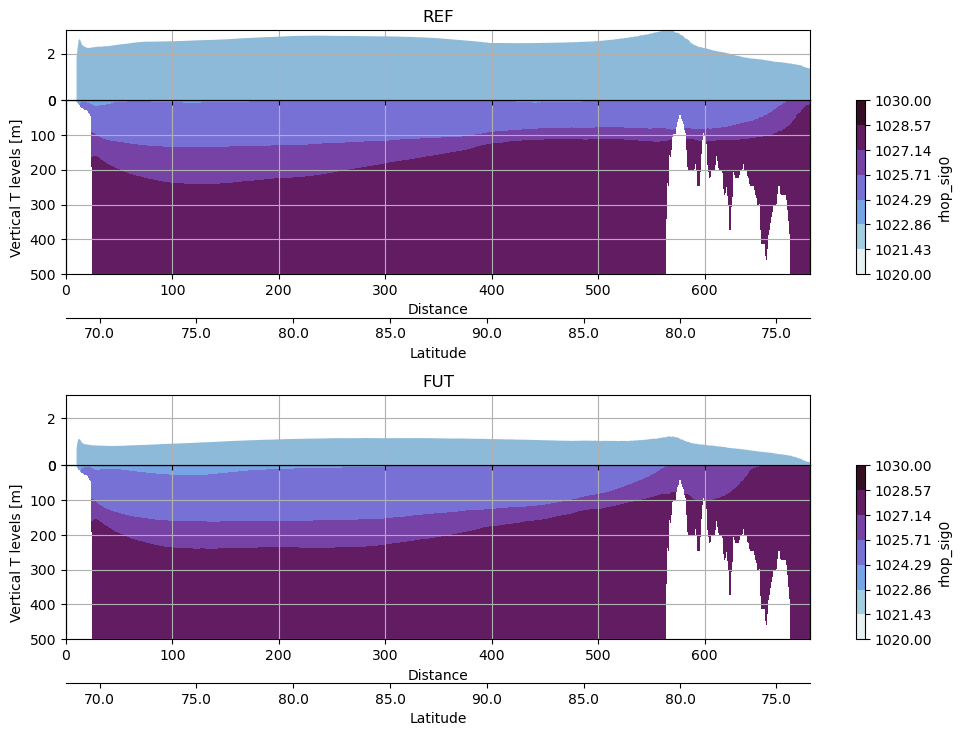

In [149]:
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(2, 1, 1)
cs = data2plot_REF_rho.where(data2plot_REF> 1000).plot.contourf(x='diag', ax=ax1,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
# ax1.clabel(cs, inline=1, fontsize=10,colors='w')



ice_ax = fig.add_axes([ax1.get_position().x0,ax1.get_position().y1,ax1.get_position().width,0.1])
# data2plot_REF_icethick.plot(ax=ice_ax)
ice_ax.fill_between(data2plot_REF_icethick.diag,data2plot_REF_icethick*0,data2plot_REF_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("REF")


ax2 = fig.add_subplot(2, 1, 2)
cs = data2plot_FUT_rho.where(data2plot_FUT> 1000).plot.contourf(x='diag',ax=ax2,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
# ax2.clabel(cs, inline=1, fontsize=10,colors='w')
ax2.set_title("FUT")


ice_ax = fig.add_axes([ax2.get_position().x0,ax2.get_position().y1-0.101,ax2.get_position().width,0.1])
# data2plot_REF_icethick.plot(ax=ice_ax)
ice_ax.fill_between(data2plot_FUT_icethick.diag,data2plot_FUT_icethick*0,data2plot_FUT_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("FUT")



ax1.set_ylim((0,500))
ax2.set_ylim((0,500))
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax2.invert_yaxis()

ax1.set_xlabel('Distance')
ax2.set_xlabel('Distance')

ax1_t = create_extra_axis(ax1)
ax2_t = create_extra_axis(ax2)

fig.canvas.draw()

labels = [item.get_text() for item in ax1_t.get_xticklabels()]
labels = [np.round(data2plot_REF.nav_lat.isel(diag=int(label)).values) for label in labels]

ax1_t.set_xticklabels(labels)
ax1_t.set_xlabel('Latitude')
ax2_t.set_xticklabels(labels)
ax2_t.set_xlabel('Latitude')

plt.subplots_adjust(hspace=1.1)


# MKE, KE + ice + density

In [154]:
MKE_REF = xr.decode_cf(xr.open_mfdataset(MKE_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 5}))

MKE_REF = MKE_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [155]:
MKE_FUT = xr.decode_cf(xr.open_mfdataset(MKE_data_filesFUT, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 5}))

MKE_FUT = MKE_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [184]:
EKE_REF = xr.decode_cf(xr.open_mfdataset(EKE_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 5}))

EKE_REF = EKE_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [161]:
EKE_FUT = xr.decode_cf(xr.open_mfdataset(EKE_data_filesFUT, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 5}))

EKE_FUT = EKE_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [170]:
transect_MKE_REF = MKE_REF.vomke.assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)
transect_MKE_FUT = MKE_FUT.vomke.assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)

In [171]:
transect_EKE_REF = EKE_REF.voeke.assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)
transect_EKE_FUT = EKE_FUT.voeke.assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)

In [172]:
diag = xr.DataArray(np.arange(700), dims="diag")
diag_transect_MKE_REF = transect_MKE_REF.isel(x_points=diag, y_points=diag)
diag_transect_MKE_FUT = transect_MKE_FUT.isel(x_points=diag, y_points=diag)

In [173]:
diag = xr.DataArray(np.arange(700), dims="diag")
diag_transect_EKE_REF = transect_EKE_REF.isel(x_points=diag, y_points=diag)
diag_transect_EKE_FUT = transect_EKE_FUT.isel(x_points=diag, y_points=diag)

In [174]:
data2plot_REF_MKE = diag_transect_MKE_REF.mean('time_counter').compute()
data2plot_FUT_MKE = diag_transect_MKE_FUT.mean('time_counter').compute()
data2plot_REF_EKE = diag_transect_EKE_REF.mean('time_counter').compute()
data2plot_FUT_EKE = diag_transect_EKE_FUT.mean('time_counter').compute()

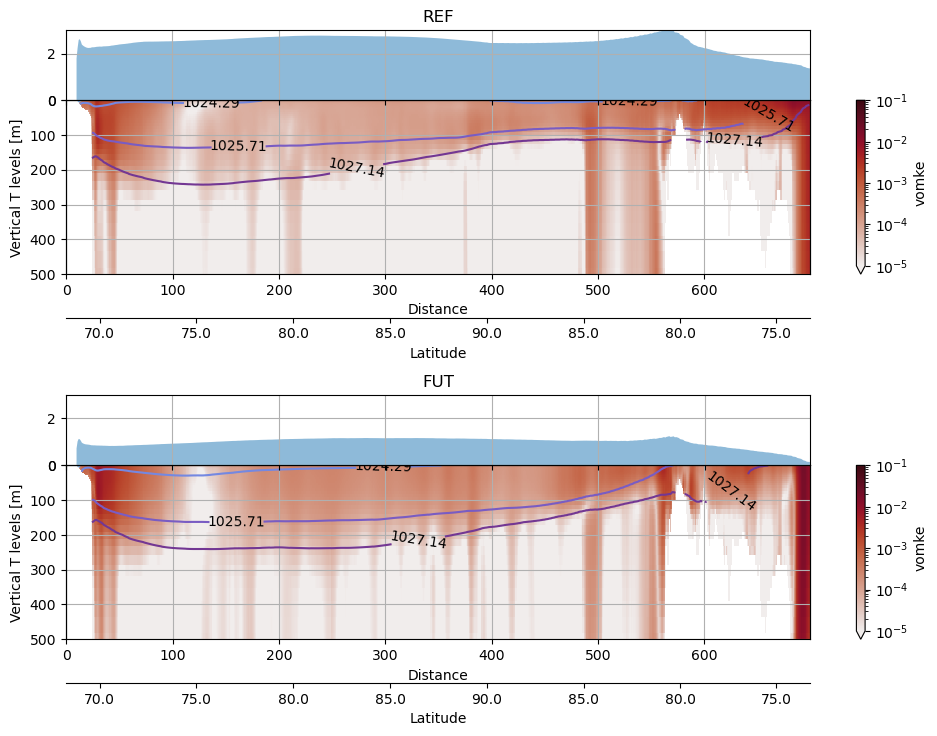

In [182]:
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(2, 1, 1)
cs = data2plot_REF_rho.where(data2plot_REF> 1000).plot.contour(x='diag', ax=ax1,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
ax1.clabel(cs, inline=1, fontsize=10,colors='k')

# Data to plot in pcolormesh
data2plot_REF_MKE.plot(ax=ax1,cmap=cmo.amp, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1))

    
# Add ice thickness above 
ice_ax = fig.add_axes([ax1.get_position().x0,ax1.get_position().y1,ax1.get_position().width,0.1])
ice_ax.fill_between(data2plot_REF_icethick.diag,data2plot_REF_icethick*0,data2plot_REF_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("REF")


ax2 = fig.add_subplot(2, 1, 2)
cs = data2plot_FUT_rho.where(data2plot_FUT> 1000).plot.contour(x='diag',ax=ax2,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
ax2.clabel(cs, inline=1, fontsize=10,colors='k')
ax2.set_title("FUT")
    
# Data to plot in pcolormesh
data2plot_FUT_MKE.plot(ax=ax2,cmap=cmo.amp, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1))

# Add ice thickness above 
ice_ax = fig.add_axes([ax2.get_position().x0,ax2.get_position().y1-0.101,ax2.get_position().width,0.1])
ice_ax.fill_between(data2plot_FUT_icethick.diag,data2plot_FUT_icethick*0,data2plot_FUT_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("FUT")

ax1.set_ylim((0,500))
ax2.set_ylim((0,500))
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax2.invert_yaxis()

ax1.set_xlabel('Distance')
ax2.set_xlabel('Distance')

ax1_t = create_extra_axis(ax1)
ax2_t = create_extra_axis(ax2)

fig.canvas.draw()

labels = [item.get_text() for item in ax1_t.get_xticklabels()]
labels = [np.round(data2plot_REF.nav_lat.isel(diag=int(label)).values) for label in labels]

ax1_t.set_xticklabels(labels)
ax1_t.set_xlabel('Latitude')
ax2_t.set_xticklabels(labels)
ax2_t.set_xlabel('Latitude')

plt.subplots_adjust(hspace=1.1)


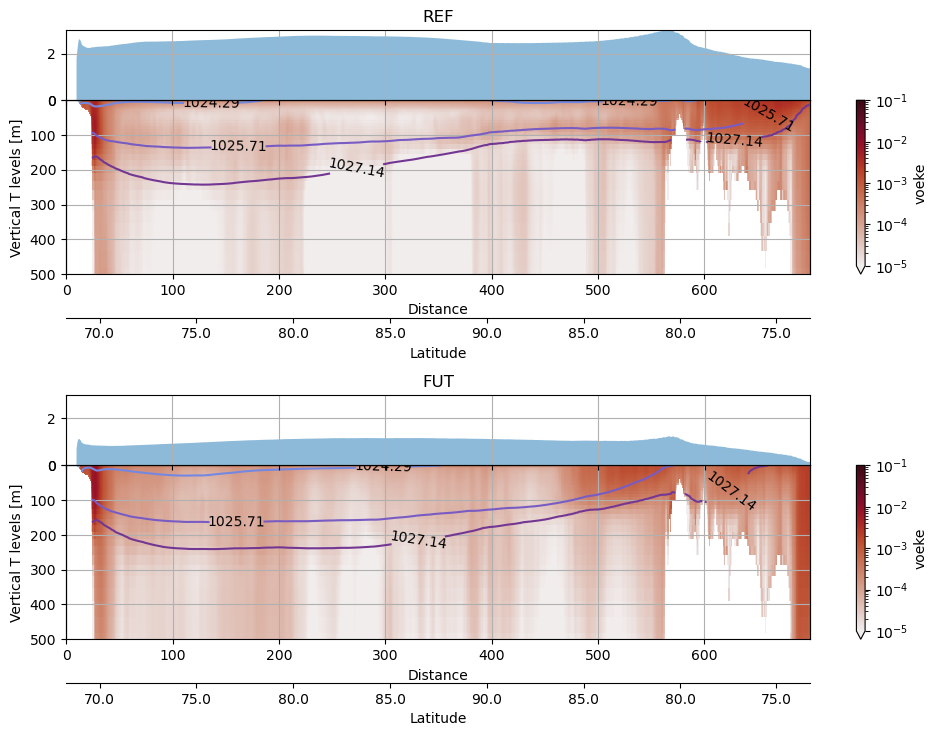

In [183]:
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(2, 1, 1)
cs = data2plot_REF_rho.where(data2plot_REF> 1000).plot.contour(x='diag', ax=ax1,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
ax1.clabel(cs, inline=1, fontsize=10,colors='k')

# Data to plot in pcolormesh
data2plot_REF_EKE.plot(ax=ax1,cmap=cmo.amp, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1))

    
# Add ice thickness above 
ice_ax = fig.add_axes([ax1.get_position().x0,ax1.get_position().y1,ax1.get_position().width,0.1])
ice_ax.fill_between(data2plot_REF_icethick.diag,data2plot_REF_icethick*0,data2plot_REF_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("REF")


ax2 = fig.add_subplot(2, 1, 2)
cs = data2plot_FUT_rho.where(data2plot_FUT> 1000).plot.contour(x='diag',ax=ax2,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
ax2.clabel(cs, inline=1, fontsize=10,colors='k')
ax2.set_title("FUT")
    
# Data to plot in pcolormesh
data2plot_FUT_EKE.plot(ax=ax2,cmap=cmo.amp, norm=colors.LogNorm(vmin=1e-5, vmax=1e-1))

# Add ice thickness above 
ice_ax = fig.add_axes([ax2.get_position().x0,ax2.get_position().y1-0.101,ax2.get_position().width,0.1])
ice_ax.fill_between(data2plot_FUT_icethick.diag,data2plot_FUT_icethick*0,data2plot_FUT_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("FUT")

ax1.set_ylim((0,500))
ax2.set_ylim((0,500))
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax2.invert_yaxis()

ax1.set_xlabel('Distance')
ax2.set_xlabel('Distance')

ax1_t = create_extra_axis(ax1)
ax2_t = create_extra_axis(ax2)

fig.canvas.draw()

labels = [item.get_text() for item in ax1_t.get_xticklabels()]
labels = [np.round(data2plot_REF.nav_lat.isel(diag=int(label)).values) for label in labels]

ax1_t.set_xticklabels(labels)
ax1_t.set_xlabel('Latitude')
ax2_t.set_xticklabels(labels)
ax2_t.set_xlabel('Latitude')

plt.subplots_adjust(hspace=1.1)


# Stratification + ice + density

In [220]:
NSQUARE_REF =xr.open_mfdataset(NSQUARE_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,concat_dim="time_counter",
                            combine="nested", preprocess=prepro, chunks={"deptht": 5})


NSQUARE_REF = NSQUARE_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [221]:
NSQUARE_FUT = xr.open_mfdataset(NSQUARE_data_filesFUT,  coords="minimal", compat="override", parallel=True, decode_cf=False,concat_dim="time_counter",
                            combine="nested", preprocess=prepro, chunks={"deptht": 5})


NSQUARE_FUT = NSQUARE_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [222]:
transect_REF = NSQUARE_REF.vobn2.assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)
transect_FUT = NSQUARE_FUT.vobn2.assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)

In [223]:
diag = xr.DataArray(np.arange(700), dims="diag")
diag_transect_REF = transect_REF.isel(x_points=diag, y_points=diag)
diag_transect_FUT = transect_FUT.isel(x_points=diag, y_points=diag)

In [228]:
data2plot_REF_nsquare = diag_transect_REF.mean('time_counter').compute()

In [229]:
data2plot_FUT_nsquare = diag_transect_FUT.mean('time_counter').compute()

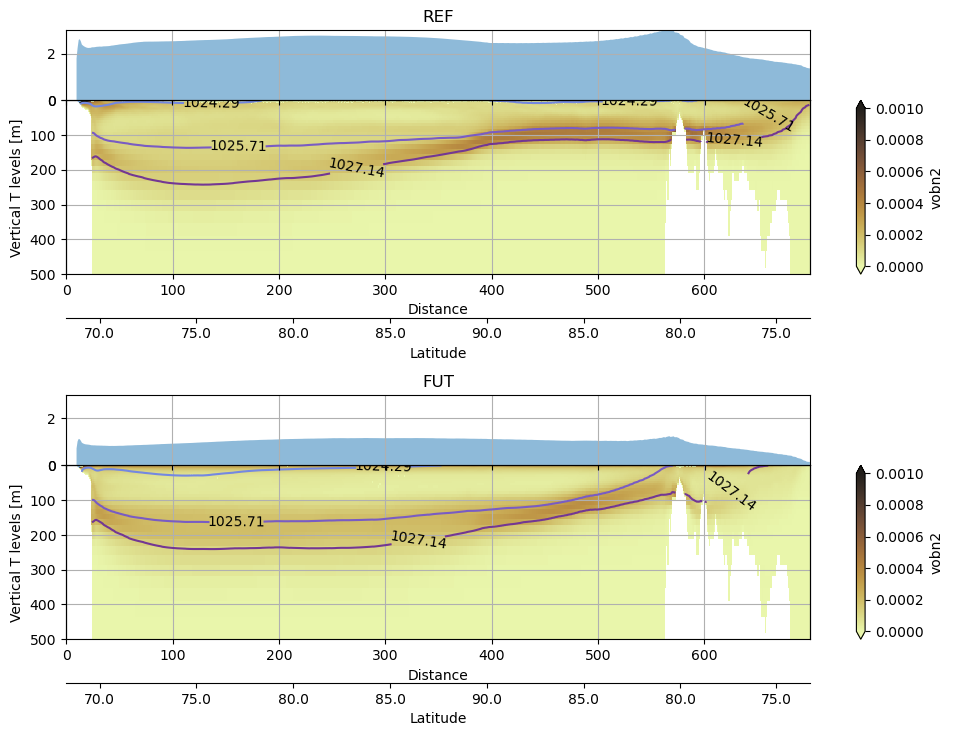

In [249]:
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(2, 1, 1)
cs = data2plot_REF_rho.where(data2plot_REF_rho> 1000).plot.contour(x='diag', ax=ax1,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
ax1.clabel(cs, inline=1, fontsize=10,colors='k')

# Data to plot in pcolormesh
data2plot_REF_nsquare.where(data2plot_REF_rho> 1000).plot(ax=ax1,cmap=cmo.turbid,vmin=0,vmax=1e-3)

    
# Add ice thickness above 
ice_ax = fig.add_axes([ax1.get_position().x0,ax1.get_position().y1,ax1.get_position().width,0.1])
ice_ax.fill_between(data2plot_REF_icethick.diag,data2plot_REF_icethick*0,data2plot_REF_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("REF")


ax2 = fig.add_subplot(2, 1, 2)
cs = data2plot_FUT_rho.where(data2plot_FUT_rho> 1000).plot.contour(x='diag',ax=ax2,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
ax2.clabel(cs, inline=1, fontsize=10,colors='k')
ax2.set_title("FUT")
    
# Data to plot in pcolormesh
data2plot_FUT_nsquare.where(data2plot_REF_rho> 1000).plot(ax=ax2,cmap=cmo.turbid,vmin=0,vmax=1e-3)

# Add ice thickness above 
ice_ax = fig.add_axes([ax2.get_position().x0,ax2.get_position().y1-0.101,ax2.get_position().width,0.1])
ice_ax.fill_between(data2plot_FUT_icethick.diag,data2plot_FUT_icethick*0,data2plot_FUT_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("FUT")

ax1.set_ylim((0,500))
ax2.set_ylim((0,500))
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax2.invert_yaxis()

ax1.set_xlabel('Distance')
ax2.set_xlabel('Distance')

ax1_t = create_extra_axis(ax1)
ax2_t = create_extra_axis(ax2)

fig.canvas.draw()

labels = [item.get_text() for item in ax1_t.get_xticklabels()]
labels = [np.round(data2plot_REF.nav_lat.isel(diag=int(label)).values) for label in labels]

ax1_t.set_xticklabels(labels)
ax1_t.set_xlabel('Latitude')
ax2_t.set_xticklabels(labels)
ax2_t.set_xlabel('Latitude')

plt.subplots_adjust(hspace=1.1)


# Shear + ice + density

In [251]:
SHEAR_REF =xr.open_mfdataset(SHEAR_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,concat_dim="time_counter",
                            combine="nested", preprocess=prepro, chunks={"deptht": 5})


SHEAR_REF = SHEAR_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [252]:
SHEAR_FUT = xr.open_mfdataset(SHEAR_data_filesFUT,  coords="minimal", compat="override", parallel=True, decode_cf=False,concat_dim="time_counter",
                            combine="nested", preprocess=prepro, chunks={"deptht": 5})


SHEAR_FUT = SHEAR_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [257]:
transect_REF = SHEAR_REF.vovshear.assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)
transect_FUT = SHEAR_FUT.vovshear.assign_coords({"x":GRIDT_REF.x,"y":GRIDT_REF.y}).isel(x=ds_xi,y=ds_yi)

/home/jmartine/.miniconda3/envs/py_gcm/lib/python3.10/site-packages/xarray/core/indexing.py:1449: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [258]:
diag = xr.DataArray(np.arange(700), dims="diag")
diag_transect_REF = transect_REF.isel(x_points=diag, y_points=diag)
diag_transect_FUT = transect_FUT.isel(x_points=diag, y_points=diag)

In [259]:
data2plot_REF_nsquare = diag_transect_REF.mean('time_counter').compute()

In [260]:
data2plot_FUT_nsquare = diag_transect_FUT.mean('time_counter').compute()

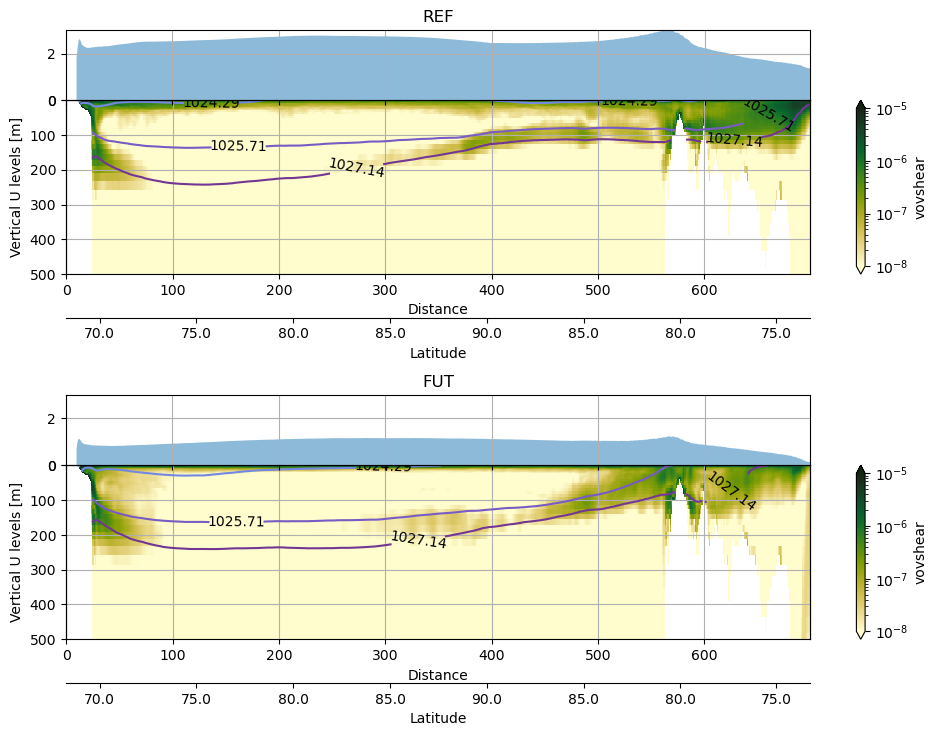

In [290]:
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(2, 1, 1)
cs = data2plot_REF_rho.where(data2plot_REF_rho> 1000).plot.contour(x='diag', ax=ax1,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
ax1.clabel(cs, inline=1, fontsize=10,colors='k')

# Data to plot in pcolormesh
data2plot_REF_nsquare.where(data2plot_REF_rho> 1000).plot(ax=ax1,cmap=cmo.speed,norm=colors.LogNorm(vmin=1e-8, vmax=1e-5))

    
# Add ice thickness above 
ice_ax = fig.add_axes([ax1.get_position().x0,ax1.get_position().y1,ax1.get_position().width,0.1])
ice_ax.fill_between(data2plot_REF_icethick.diag,data2plot_REF_icethick*0,data2plot_REF_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("REF")


ax2 = fig.add_subplot(2, 1, 2)
cs = data2plot_FUT_rho.where(data2plot_FUT_rho> 1000).plot.contour(x='diag',ax=ax2,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
ax2.clabel(cs, inline=1, fontsize=10,colors='k')
ax2.set_title("FUT")
    
# Data to plot in pcolormesh
data2plot_FUT_nsquare.where(data2plot_REF_rho> 1000).plot(ax=ax2,cmap=cmo.speed,norm=colors.LogNorm(vmin=1e-8, vmax=1e-5))

# Add ice thickness above 
ice_ax = fig.add_axes([ax2.get_position().x0,ax2.get_position().y1-0.101,ax2.get_position().width,0.1])
ice_ax.fill_between(data2plot_FUT_icethick.diag,data2plot_FUT_icethick*0,data2plot_FUT_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("FUT")

ax1.set_ylim((0,500))
ax2.set_ylim((0,500))
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax2.invert_yaxis()

ax1.set_xlabel('Distance')
ax2.set_xlabel('Distance')

ax1_t = create_extra_axis(ax1)
ax2_t = create_extra_axis(ax2)

fig.canvas.draw()

labels = [item.get_text() for item in ax1_t.get_xticklabels()]
labels = [np.round(data2plot_REF.nav_lat.isel(diag=int(label)).values) for label in labels]

ax1_t.set_xticklabels(labels)
ax1_t.set_xlabel('Latitude')
ax2_t.set_xticklabels(labels)
ax2_t.set_xlabel('Latitude')

plt.subplots_adjust(hspace=1.1)


# PV + ice + density

In [284]:
PV_REF = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-PVORT/transect.nc')
PV_FUT = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-PVORT/transect.nc')

In [286]:
data2plot_REF_PV = PV_REF.vototvor.differentiate('diag')
data2plot_FUT_PV = PV_FUT.vototvor.differentiate('diag')

/home/jmartine/.miniconda3/envs/py_gcm/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/jmartine/.miniconda3/envs/py_gcm/lib/python3.10/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/jmartine/.miniconda3/envs/py_gcm/lib/python3.10/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/jmartine/.miniconda3/envs/py_gcm/lib/python3.10/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [287]:
data2plot_REF_PV['diag'] = data2plot_FUT_nsquare.diag
data2plot_FUT_PV['diag'] = data2plot_FUT_nsquare.diag

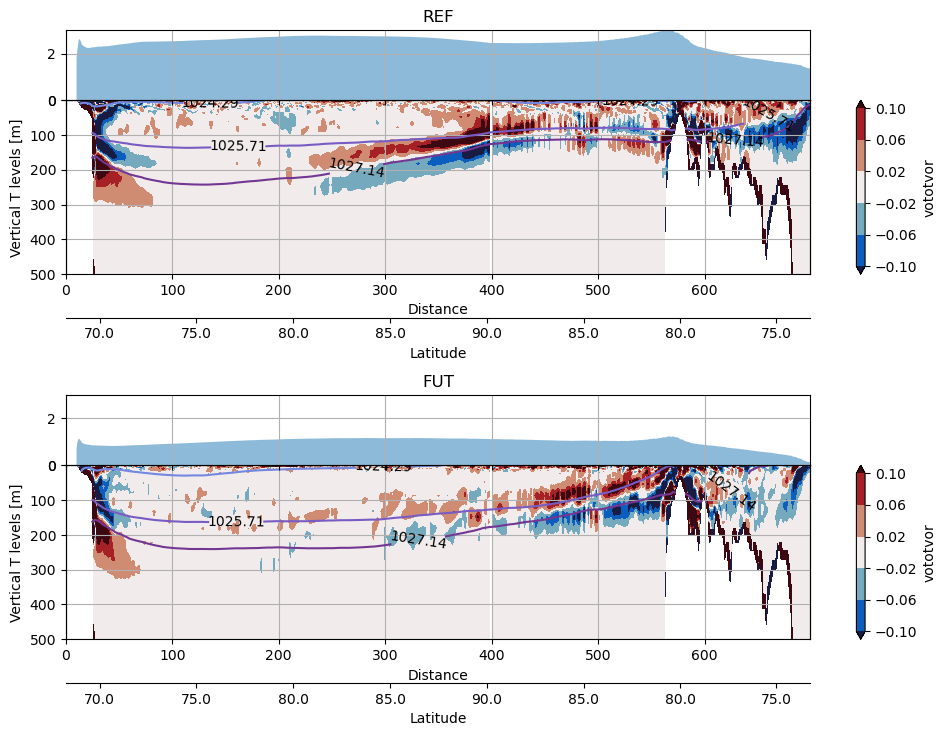

In [292]:
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(2, 1, 1)
cs = data2plot_REF_rho.where(data2plot_REF_rho> 1000).plot.contour(x='diag', ax=ax1,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
ax1.clabel(cs, inline=1, fontsize=10,colors='k')

# Data to plot in pcolormesh
data2plot_REF_PV.where(data2plot_REF_rho> 1000).plot.contourf(ax=ax1,cmap=cmo.balance,vmin=-0.1,vmax=0.1,levels=6)

    
# Add ice thickness above 
ice_ax = fig.add_axes([ax1.get_position().x0,ax1.get_position().y1,ax1.get_position().width,0.1])
ice_ax.fill_between(data2plot_REF_icethick.diag,data2plot_REF_icethick*0,data2plot_REF_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("REF")


ax2 = fig.add_subplot(2, 1, 2)
cs = data2plot_FUT_rho.where(data2plot_FUT_rho> 1000).plot.contour(x='diag',ax=ax2,vmin=1020,vmax=1030,cmap=cmo.dense,levels=8)
ax2.clabel(cs, inline=1, fontsize=10,colors='k')
ax2.set_title("FUT")
    
# Data to plot in pcolormesh
data2plot_FUT_PV.where(data2plot_REF_rho> 1000).plot.contourf(ax=ax2,cmap=cmo.balance,vmin=-0.1,vmax=0.1,levels=6)

# Add ice thickness above 
ice_ax = fig.add_axes([ax2.get_position().x0,ax2.get_position().y1-0.101,ax2.get_position().width,0.1])
ice_ax.fill_between(data2plot_FUT_icethick.diag,data2plot_FUT_icethick*0,data2plot_FUT_icethick,alpha=0.5)
ice_ax.grid()
ice_ax.set_ylim((0,3))
ice_ax.set_xlim((0,699))
ice_ax.xaxis.set_ticklabels([])
ice_ax.set_title("FUT")

ax1.set_ylim((0,500))
ax2.set_ylim((0,500))
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax2.invert_yaxis()

ax1.set_xlabel('Distance')
ax2.set_xlabel('Distance')

ax1_t = create_extra_axis(ax1)
ax2_t = create_extra_axis(ax2)

fig.canvas.draw()

labels = [item.get_text() for item in ax1_t.get_xticklabels()]
labels = [np.round(data2plot_REF.nav_lat.isel(diag=int(label)).values) for label in labels]

ax1_t.set_xticklabels(labels)
ax1_t.set_xlabel('Latitude')
ax2_t.set_xticklabels(labels)
ax2_t.set_xlabel('Latitude')

plt.subplots_adjust(hspace=1.1)
